In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random

In [2]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [39]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
file2exercise = {"../alphapose_res/irimi_tenkan_kps.json":"ирими тенкан", 
                 "../alphapose_res/ta_tracking.json":"цуги аши",
                 "../alphapose_res/utmt_kps.json":"уширо тенкан мае тенкан"}
single_st_ann = "../data/single_student_annotations.json"


SAMPLE_MAX_FRAME_COUNT = 192 # ?
CHANNELS = 3
EMB_DIM = 2

# Подготовка данных

In [4]:
from dataproc import *
from train_utils import * 

In [31]:
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                            "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
idx2error, exercise2points, exercise2errors = parse_annotations(file2mapping, single_st_ann, annotations_map, 
                                                                ss_vid_ann, single_student_tids, file2exercise)

## Датасет

In [40]:
class AutoencoderDataset(Dataset):
    def __init__(self, images:list, transform):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        return self.transform(img)

tform = T.Compose([
    T.Lambda(lambda ar: resample_to_frame_length(ar, SAMPLE_MAX_FRAME_COUNT)),
    #T.Lambda(lambda ar: random_mirroring(ar, 0)),
    T.Lambda(normalize01),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
])

In [41]:
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

#train_data, test_data, val_data = fraction_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, 42)
train_data, test_data, val_data = stratify_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, 42)
train_imgs, train_labels = train_data
test_imgs, test_labels = test_data
val_imgs, val_labels = val_data
total_data_count = len(train_imgs) + len(test_imgs) + len(val_imgs)

print("Total", total_data_count)
print("Train count", len(train_imgs))
print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Total 297
Train count 208
Test count 56
Val count 33


In [42]:
train_ds = AutoencoderDataset(train_imgs, tform)
val_ds = AutoencoderDataset(val_imgs, tform)
test_ds = AutoencoderDataset(test_imgs, tform)

Dataloader

In [43]:
# setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False)
test_loader = DataLoader(test_ds, 1, shuffle=False)

In [44]:
train_ds[0].shape

torch.Size([3, 26, 192])

# Определение автокодировщика

Код для обучения и архитектуры модели взят из:

https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [45]:
class Encoder(nn.Module):
    def __init__(self, channels, embedding_dim):
        super(Encoder, self).__init__()
        # define convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # variable to store the shape of the output tensor before flattening
        # the features, it will be used in decoders input while reconstructing
        self.shape_before_flattening = None
        # compute the flattened size after convolutions
        flattened_size = 128 * 4 * 24 # from input of 26 * 192 to 4 * 24
        # define fully connected layer to create embeddings
        self.fc = nn.Linear(flattened_size, embedding_dim)
    def forward(self, x):
        # apply ReLU activations after each convolutional layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # store the shape before flattening
        self.shape_before_flattening = x.shape[1:]
        # flatten the tensor
        x = x.view(x.size(0), -1)
        # apply fully connected layer to generate embeddings
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        # define fully connected layer to unflatten the embeddings
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        # store the shape before flattening
        self.reshape_dim = shape_before_flattening
        # define transpose convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=(1, 0), output_padding=(0, 1)
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        # define final convolutional layer to generate output image
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # apply fully connected layer to unflatten the embeddings
        x = self.fc(x)
        # reshape the tensor to match shape before flattening
        x = x.view(x.size(0), *self.reshape_dim)
        # apply ReLU activations after each transpose convolutional layer
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # apply sigmoid activation to the final convolutional layer to generate output image
        x = torch.sigmoid(self.conv1(x)) 
        #x = F.tanh(self.conv1(x))
        return x

# Обучение

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 100
device

'cuda'

In [47]:
encoder = Encoder(channels=CHANNELS, embedding_dim=EMB_DIM).to(device)
# pass the dummy input through the encoder and
# get the output (encoded representation)
dummy_input = torch.rand(1, 3, 26, 192)
enc_out = encoder(dummy_input.to(device))
# get the shape of the tensor before it was flattened in the encoder
shape_before_flattening = encoder.shape_before_flattening
# create a decoder instance with the specified embedding dimensions,
# shape before flattening, and channels
# then move it to the device (CPU or GPU) specified in the config
decoder = Decoder(EMB_DIM, shape_before_flattening, CHANNELS).to(device)
# instantiate loss, optimizer, and scheduler
criterion = nn.MSELoss() #nn.BCELoss() # MSE, MAE
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

In [48]:
inprogress_metrics = {"MAE":F.l1_loss} #, "MSE":F.mse_loss

def calc_metrics(preds, targets, inprogress_metrics):
    report = dict()
    for metric in inprogress_metrics:
        metric_func = inprogress_metrics[metric]
        mval = metric_func(preds, targets)
        report[metric] = round(mval.item(), 3)
    return report

def print_report(loss_value, metric_vals, beginning):
    addition = []
    for km in metric_vals:
        formatteds = f"{km}: {metric_vals[km]} "
        addition.append(formatteds)    
    print(beginning, "Loss:", loss_value, "".join(addition))

def train_one_epoch(encoder, decoder, loader, criterion, optimizer, epoch_num):
    encoder.train()
    decoder.train()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    for batch_idx, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_num}"):
        # move the data to the device (GPU or CPU)
        data = data.to(device)
        # reset the gradients of the optimizer
        optimizer.zero_grad()
        # forward pass: encode the data and decode the encoded representation
        encoded = encoder(data)
        decoded = decoder(encoded)
        # compute the reconstruction loss between the decoded output and
        # the original data
        loss = criterion(decoded, data)
        # backward pass: compute the gradients
        loss.backward()
        # update the model weights
        optimizer.step()
        # accumulate the loss for the current batch
        running_loss += loss.item()
        metrics = calc_metrics(decoded, data, inprogress_metrics)
        for m in metrics:
            running_metrics[m] += metrics[m]
    # compute the average training loss for the epoch
    train_loss = running_loss / len(loader)
    train_metrics = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(train_loss, train_metrics, "Train|")

    res = dict(train_metrics)
    res["loss"] = train_loss
    return res

def evaluate(encoder, decoder, loader, criterion):
    encoder.eval() 
    decoder.eval()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            encoded = encoder(data)
            decoded = decoder(encoded)
            loss = criterion(decoded, data)
            running_loss += loss.item()
            metrics = calc_metrics(decoded, data, inprogress_metrics)
            for m in metrics:
                running_metrics[m] += metrics[m]
    l = running_loss / len(loader)
    scores = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(l, scores, "Valid|")
    
    res = dict(scores)
    res["loss"] = l
    return res


In [49]:
train_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}
val_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}

for epoch in range(epochs):
    #print(f"Epoch: {epoch + 1}/{epochs}")
    tvals = train_one_epoch(encoder, decoder, train_loader, criterion, optimizer, epoch)
    vvals = evaluate(encoder, decoder, val_loader, criterion)
    for k in tvals:
        train_history[k].append(tvals[k])
        val_history[k].append(vvals[k])
    # adjust learning rate based on the validation loss
    scheduler.step(vvals["loss"])
    

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]


Train| Loss: 0.12896402712379182 MAE: 0.323 
Valid| Loss: 0.1077776588499546 MAE: 0.2835 


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 104.42it/s]


Train| Loss: 0.11075283693415779 MAE: 0.29157142857142854 
Valid| Loss: 0.10038484260439873 MAE: 0.2725 


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 87.87it/s]


Train| Loss: 0.09292708869491305 MAE: 0.2582857142857143 
Valid| Loss: 0.0856933444738388 MAE: 0.2465 


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 106.17it/s]


Train| Loss: 0.0783308031303542 MAE: 0.2238571428571429 
Valid| Loss: 0.08023089542984962 MAE: 0.2385 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.59it/s]


Train| Loss: 0.0720748347895486 MAE: 0.20957142857142855 
Valid| Loss: 0.07559774816036224 MAE: 0.22949999999999998 


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 89.41it/s]


Train| Loss: 0.06602876048002924 MAE: 0.19500000000000003 
Valid| Loss: 0.07095413655042648 MAE: 0.219 


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 104.58it/s]


Train| Loss: 0.06280913257173129 MAE: 0.18657142857142855 
Valid| Loss: 0.06462524458765984 MAE: 0.20650000000000002 


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.93it/s]


Train| Loss: 0.05708800043378558 MAE: 0.17771428571428569 
Valid| Loss: 0.055018775165081024 MAE: 0.185 


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 92.45it/s]


Train| Loss: 0.04643897392920086 MAE: 0.15257142857142858 
Valid| Loss: 0.04043351672589779 MAE: 0.1485 


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 104.58it/s]


Train| Loss: 0.03807117390845503 MAE: 0.12914285714285714 
Valid| Loss: 0.03461591713130474 MAE: 0.1305 


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.77it/s]


Train| Loss: 0.033297562173434665 MAE: 0.11957142857142856 
Valid| Loss: 0.02908326778560877 MAE: 0.12 


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.49it/s]


Train| Loss: 0.03201486862131527 MAE: 0.11457142857142856 
Valid| Loss: 0.026454702951014042 MAE: 0.11 


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 98.63it/s]


Train| Loss: 0.029724405812365667 MAE: 0.1087142857142857 
Valid| Loss: 0.02588675357401371 MAE: 0.1085 


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 100.70it/s]


Train| Loss: 0.028930532612970898 MAE: 0.107 
Valid| Loss: 0.025745276361703873 MAE: 0.107 


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.12it/s]


Train| Loss: 0.028701303792851313 MAE: 0.10442857142857143 
Valid| Loss: 0.0247415229678154 MAE: 0.1065 


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.18it/s]


Train| Loss: 0.027417383023670742 MAE: 0.10371428571428572 
Valid| Loss: 0.024345778860151768 MAE: 0.10250000000000001 


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.88it/s]


Train| Loss: 0.027310062998107502 MAE: 0.10157142857142856 
Valid| Loss: 0.024522543884813786 MAE: 0.105 


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 106.93it/s]


Train| Loss: 0.026816200464963913 MAE: 0.10214285714285713 
Valid| Loss: 0.024184350855648518 MAE: 0.101 


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.58it/s]


Train| Loss: 0.02645712984459741 MAE: 0.10014285714285713 
Valid| Loss: 0.024510719813406467 MAE: 0.10350000000000001 


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.95it/s]


Train| Loss: 0.026398478874138424 MAE: 0.09928571428571428 
Valid| Loss: 0.02265980839729309 MAE: 0.0985 


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 105.81it/s]


Train| Loss: 0.025235714656966075 MAE: 0.09728571428571428 
Valid| Loss: 0.02420277427881956 MAE: 0.10300000000000001 


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.53it/s]


Train| Loss: 0.024999128388507024 MAE: 0.09728571428571428 
Valid| Loss: 0.023528295569121838 MAE: 0.1 


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.84it/s]


Train| Loss: 0.024458233000976697 MAE: 0.09728571428571428 
Valid| Loss: 0.024317441508173943 MAE: 0.10450000000000001 
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.42it/s]


Train| Loss: 0.02360182548207896 MAE: 0.09499999999999999 
Valid| Loss: 0.022794311866164207 MAE: 0.099 


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 87.81it/s]


Train| Loss: 0.023777916761381284 MAE: 0.09457142857142857 
Valid| Loss: 0.022279337979853153 MAE: 0.0975 


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 89.35it/s]


Train| Loss: 0.023611802075590407 MAE: 0.09371428571428572 
Valid| Loss: 0.022403070703148842 MAE: 0.098 


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.77it/s]


Train| Loss: 0.02329330039875848 MAE: 0.09385714285714285 
Valid| Loss: 0.022530216723680496 MAE: 0.099 


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 92.92it/s]


Train| Loss: 0.022800945543817112 MAE: 0.09314285714285712 
Valid| Loss: 0.022446854040026665 MAE: 0.098 
Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 95.71it/s]


Train| Loss: 0.022658559892858778 MAE: 0.09242857142857143 
Valid| Loss: 0.022415943443775177 MAE: 0.098 


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.14it/s]


Train| Loss: 0.023352706006595066 MAE: 0.09399999999999999 
Valid| Loss: 0.02241270523518324 MAE: 0.098 


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 86.42it/s]


Train| Loss: 0.022403043561748097 MAE: 0.09228571428571428 
Valid| Loss: 0.022375009022653103 MAE: 0.098 
Epoch 00031: reducing learning rate of group 0 to 1.0000e-06.


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 98.07it/s]


Train| Loss: 0.022613727088485445 MAE: 0.09271428571428572 
Valid| Loss: 0.02237251028418541 MAE: 0.098 


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.45it/s]


Train| Loss: 0.023244324273296764 MAE: 0.09399999999999999 
Valid| Loss: 0.02237183414399624 MAE: 0.098 


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 99.19it/s]


Train| Loss: 0.022979663152779852 MAE: 0.09299999999999999 
Valid| Loss: 0.022369710728526115 MAE: 0.098 
Epoch 00034: reducing learning rate of group 0 to 1.0000e-07.


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 110.61it/s]


Train| Loss: 0.02236418253076928 MAE: 0.09214285714285712 
Valid| Loss: 0.022369559854269028 MAE: 0.098 


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.24it/s]


Train| Loss: 0.022906757092901638 MAE: 0.09342857142857142 
Valid| Loss: 0.022369449958205223 MAE: 0.098 


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 86.92it/s]


Train| Loss: 0.023415078542062213 MAE: 0.09399999999999999 
Valid| Loss: 0.02236912027001381 MAE: 0.098 
Epoch 00037: reducing learning rate of group 0 to 1.0000e-08.


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 88.87it/s]


Train| Loss: 0.022562466827886447 MAE: 0.09285714285714285 
Valid| Loss: 0.022369087673723698 MAE: 0.098 


Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.17it/s]


Train| Loss: 0.023110113771898404 MAE: 0.09328571428571428 
Valid| Loss: 0.02236907370388508 MAE: 0.098 


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.59it/s]


Train| Loss: 0.02310196895684515 MAE: 0.09357142857142856 
Valid| Loss: 0.022368994541466236 MAE: 0.098 


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.38it/s]


Train| Loss: 0.022293662652373314 MAE: 0.092 
Valid| Loss: 0.022368994541466236 MAE: 0.098 


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 88.20it/s]


Train| Loss: 0.02310320415667125 MAE: 0.09385714285714286 
Valid| Loss: 0.022368970327079296 MAE: 0.098 


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.10it/s]


Train| Loss: 0.02313568868807384 MAE: 0.09357142857142856 
Valid| Loss: 0.02236898522824049 MAE: 0.098 


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.89it/s]


Train| Loss: 0.022503798561436788 MAE: 0.09214285714285712 
Valid| Loss: 0.022368968464434147 MAE: 0.098 


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.39it/s]


Train| Loss: 0.022843956149050167 MAE: 0.09342857142857142 
Valid| Loss: 0.022368947975337505 MAE: 0.098 


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.62it/s]


Train| Loss: 0.02339805050620011 MAE: 0.09428571428571428 
Valid| Loss: 0.02236895728856325 MAE: 0.098 


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 92.29it/s]


Train| Loss: 0.02331483124622277 MAE: 0.09342857142857142 
Valid| Loss: 0.022368929348886013 MAE: 0.098 


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.34it/s]


Train| Loss: 0.023353899163859233 MAE: 0.09414285714285713 
Valid| Loss: 0.02236894052475691 MAE: 0.098 


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.30it/s]


Train| Loss: 0.022461558293019022 MAE: 0.09228571428571428 
Valid| Loss: 0.022368899546563625 MAE: 0.098 


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 95.04it/s]


Train| Loss: 0.022880176082253456 MAE: 0.09299999999999999 
Valid| Loss: 0.02236889023333788 MAE: 0.098 


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 97.23it/s]


Train| Loss: 0.02317154380892004 MAE: 0.09399999999999999 
Valid| Loss: 0.022368899546563625 MAE: 0.098 


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 99.85it/s]


Train| Loss: 0.023104367245520865 MAE: 0.09371428571428571 
Valid| Loss: 0.022368879057466984 MAE: 0.098 


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.06it/s]


Train| Loss: 0.022570479661226273 MAE: 0.09271428571428571 
Valid| Loss: 0.022368880920112133 MAE: 0.098 


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 96.63it/s]


Train| Loss: 0.022992523120982305 MAE: 0.09342857142857143 
Valid| Loss: 0.02236886601895094 MAE: 0.098 


Epoch 54: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.49it/s]


Train| Loss: 0.022553153868232454 MAE: 0.09228571428571428 
Valid| Loss: 0.022368847392499447 MAE: 0.098 


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 97.85it/s]


Train| Loss: 0.02272441184946469 MAE: 0.09271428571428571 
Valid| Loss: 0.022368797101080418 MAE: 0.098 


Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 110.79it/s]


Train| Loss: 0.023048666172793934 MAE: 0.09328571428571428 
Valid| Loss: 0.022368766367435455 MAE: 0.098 


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.14it/s]


Train| Loss: 0.022556465917399952 MAE: 0.09228571428571429 
Valid| Loss: 0.022368723526597023 MAE: 0.098 


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.00it/s]


Train| Loss: 0.022612461021968296 MAE: 0.09228571428571428 
Valid| Loss: 0.022368685342371464 MAE: 0.098 


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.00it/s]


Train| Loss: 0.023078416607209613 MAE: 0.09357142857142856 
Valid| Loss: 0.02236865647137165 MAE: 0.098 


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 80.75it/s]


Train| Loss: 0.023644763976335526 MAE: 0.09457142857142857 
Valid| Loss: 0.022368661127984524 MAE: 0.098 


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 80.77it/s]


Train| Loss: 0.022613612668854848 MAE: 0.09257142857142855 
Valid| Loss: 0.022368641570210457 MAE: 0.098 


Epoch 62: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 105.87it/s]


Train| Loss: 0.022563553282192776 MAE: 0.09214285714285715 
Valid| Loss: 0.022368624806404114 MAE: 0.098 


Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 103.11it/s]


Train| Loss: 0.022971730679273605 MAE: 0.09342857142857143 
Valid| Loss: 0.022368621081113815 MAE: 0.098 


Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 100.51it/s]


Train| Loss: 0.023595341348222325 MAE: 0.09428571428571429 
Valid| Loss: 0.02236858196556568 MAE: 0.098 


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 85.87it/s]


Train| Loss: 0.023119846358895302 MAE: 0.09328571428571429 
Valid| Loss: 0.022368562407791615 MAE: 0.098 


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 79.38it/s]


Train| Loss: 0.022386636718043258 MAE: 0.09185714285714286 
Valid| Loss: 0.02236854936927557 MAE: 0.098 


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 89.23it/s]


Train| Loss: 0.023708673992327282 MAE: 0.09485714285714285 
Valid| Loss: 0.022368540056049824 MAE: 0.098 


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.97it/s]


Train| Loss: 0.02283919309931142 MAE: 0.09271428571428571 
Valid| Loss: 0.022368543781340122 MAE: 0.098 


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 79.77it/s]


Train| Loss: 0.023414483293890953 MAE: 0.09385714285714285 
Valid| Loss: 0.022368536330759525 MAE: 0.098 


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.14it/s]


Train| Loss: 0.02341501441385065 MAE: 0.09428571428571428 
Valid| Loss: 0.0223685335367918 MAE: 0.098 


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.18it/s]


Train| Loss: 0.02284382576388972 MAE: 0.09285714285714285 
Valid| Loss: 0.022368512116372585 MAE: 0.098 


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.34it/s]


Train| Loss: 0.02304313491497721 MAE: 0.09342857142857142 
Valid| Loss: 0.02236848510801792 MAE: 0.098 


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 87.01it/s]


Train| Loss: 0.023406764758484706 MAE: 0.09371428571428571 
Valid| Loss: 0.02236852888017893 MAE: 0.098 


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 86.96it/s]


Train| Loss: 0.022442873833434924 MAE: 0.09257142857142855 
Valid| Loss: 0.022368503734469414 MAE: 0.098 


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.44it/s]


Train| Loss: 0.02282522352678435 MAE: 0.09314285714285712 
Valid| Loss: 0.022368530742824078 MAE: 0.098 


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 93.06it/s]


Train| Loss: 0.022546028718352318 MAE: 0.09228571428571428 
Valid| Loss: 0.022368503734469414 MAE: 0.098 


Epoch 77: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 100.24it/s]


Train| Loss: 0.022724972239562442 MAE: 0.09257142857142855 
Valid| Loss: 0.02236850280314684 MAE: 0.098 


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 96.76it/s]

Train| Loss: 0.022840970594968115 MAE: 0.09314285714285712 


Valid| Loss: 0.022368489764630795 MAE: 0.098 


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 89.57it/s]


Train| Loss: 0.023041113944990293 MAE: 0.09357142857142856 
Valid| Loss: 0.02236850280314684 MAE: 0.098 


Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.29it/s]


Train| Loss: 0.02354513294994831 MAE: 0.09428571428571428 
Valid| Loss: 0.022368486039340496 MAE: 0.098 


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 82.86it/s]


Train| Loss: 0.022723635392529622 MAE: 0.09257142857142855 
Valid| Loss: 0.022368447855114937 MAE: 0.098 


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.05it/s]


Train| Loss: 0.022592544821756228 MAE: 0.09242857142857142 
Valid| Loss: 0.022368449717760086 MAE: 0.098 


Epoch 83: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 104.86it/s]


Train| Loss: 0.022372590244880745 MAE: 0.09199999999999998 
Valid| Loss: 0.02236844040453434 MAE: 0.098 


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 96.46it/s]


Train| Loss: 0.023167066808257784 MAE: 0.09371428571428571 
Valid| Loss: 0.02236840222030878 MAE: 0.098 


Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 100.96it/s]


Train| Loss: 0.02284538745880127 MAE: 0.093 
Valid| Loss: 0.022368397563695908 MAE: 0.098 


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 83.96it/s]


Train| Loss: 0.022872022220066617 MAE: 0.093 
Valid| Loss: 0.022368397563695908 MAE: 0.098 


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 97.96it/s]


Train| Loss: 0.023352638419185365 MAE: 0.09371428571428571 
Valid| Loss: 0.02236842643469572 MAE: 0.098 


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 88.33it/s]


Train| Loss: 0.022487221285700798 MAE: 0.09214285714285712 
Valid| Loss: 0.022368443198502064 MAE: 0.098 


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.07it/s]


Train| Loss: 0.022501311930162565 MAE: 0.09214285714285712 
Valid| Loss: 0.02236843854188919 MAE: 0.098 


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.16it/s]


Train| Loss: 0.022689816941108023 MAE: 0.09242857142857142 
Valid| Loss: 0.022368432953953743 MAE: 0.098 


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 82.02it/s]


Train| Loss: 0.023072986464415277 MAE: 0.09342857142857143 
Valid| Loss: 0.022368385456502438 MAE: 0.098 


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 94.07it/s]


Train| Loss: 0.023201162261622294 MAE: 0.09342857142857143 
Valid| Loss: 0.022368396632373333 MAE: 0.098 


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 92.26it/s]


Train| Loss: 0.022619667063866342 MAE: 0.09285714285714285 
Valid| Loss: 0.022368391044437885 MAE: 0.098 


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 94.80it/s]


Train| Loss: 0.02253801961030279 MAE: 0.09271428571428571 
Valid| Loss: 0.022368394769728184 MAE: 0.098 


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 90.84it/s]


Train| Loss: 0.022698359031762396 MAE: 0.09285714285714285 
Valid| Loss: 0.02236841805279255 MAE: 0.098 


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 99.66it/s]


Train| Loss: 0.022518630538667952 MAE: 0.09214285714285712 
Valid| Loss: 0.022368408739566803 MAE: 0.098 


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 98.63it/s]


Train| Loss: 0.022997488134673665 MAE: 0.09342857142857142 
Valid| Loss: 0.02236833982169628 MAE: 0.098 


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.69it/s]


Train| Loss: 0.022690086226378168 MAE: 0.09257142857142855 
Valid| Loss: 0.022368330508470535 MAE: 0.098 


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 91.07it/s]


Train| Loss: 0.02295621537736484 MAE: 0.09314285714285712 
Valid| Loss: 0.022368337959051132 MAE: 0.098 


In [50]:
# displaying losses
def plot_metrics(train_hist:dict, val_hist:dict):
    metrics_name = [metr_name for metr_name in train_hist if metr_name!="loss"]
    plot_counts = len(metrics_name)
    fig, axs = plt.subplots(1, len(metrics_name), figsize=(9, 3), squeeze=False)
    for idx, mname in enumerate(metrics_name):
        train_mvals = train_hist[mname]
        val_mvals = val_hist[mname]
        axs[0, idx].plot(train_mvals, '-b')
        axs[0, idx].plot(val_mvals, '-r')
        axs[0, idx].set_xlabel(mname)
        axs[0, idx].legend(['Training', 'Validation'])
    fig.suptitle(', '.join(metrics_name)+' vs No. of epochs');
    
def plot_losses(train_hist:dict, val_hist:dict, loss_name:str):
    train_losses = train_hist["loss"]
    val_losses = val_hist["loss"]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title(f'{loss_name} Loss vs. No. of epochs');

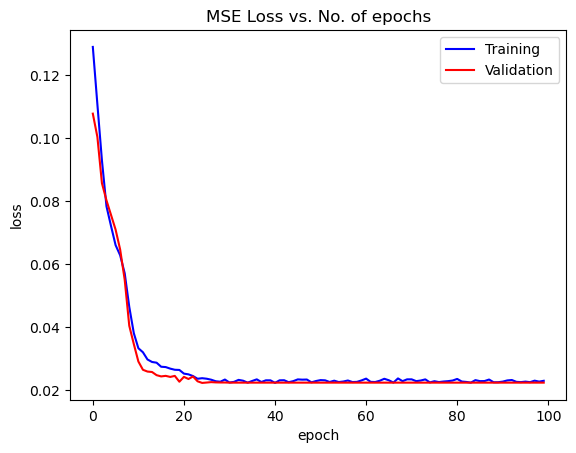

In [51]:
plot_losses(train_history, val_history, "MSE")

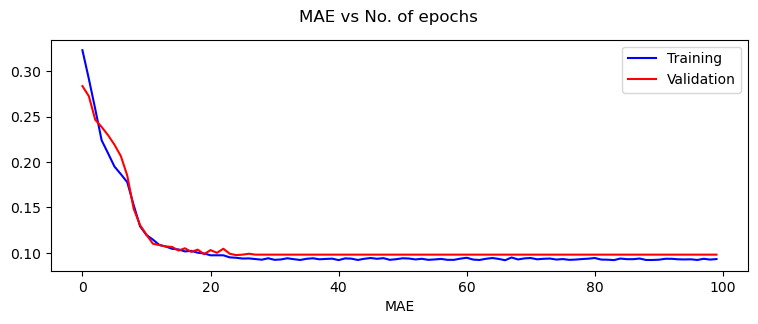

In [52]:
plot_metrics(train_history, val_history)

# Тестирование

In [53]:
encoder.eval() 
decoder.eval()

preds = []
trues = []
test_history = {k:0.0 for k in inprogress_metrics}
running_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        encoded = encoder(data)
        decoded = decoder(encoded)
        trues.append(data.cpu().permute((0, 2, 3, 1)).numpy().squeeze())
        preds.append(decoded.cpu().permute((0, 2, 3, 1)).numpy().squeeze())
        loss = criterion(decoded, data)
        running_loss += loss.item()
        metrics = calc_metrics(decoded, data, inprogress_metrics)
        for m in metrics:
            test_history[m] += metrics[m]
l = running_loss / len(test_loader)
scores = {k:(test_history[k] / len(test_loader)) for k in test_history}
print_report(l, scores, "Test|")

Test| Loss: 0.025165819346771708 MAE: 0.0971964285714286 


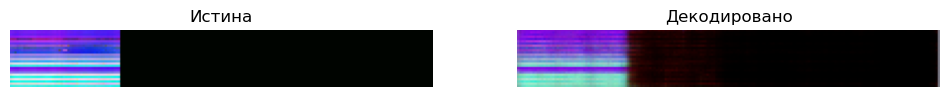

In [54]:
def compare_true_recon(inp_img, decoded):
    fig, axs = plt.subplots(1, 2, figsize=(12, 16))
    axs[0].imshow(inp_img)
    axs[0].set_title("Истина")
    axs[0].axis("off")
    axs[1].imshow(decoded)
    axs[1].set_title("Декодировано")
    axs[1].axis("off")
    plt.show()

compare_true_recon(trues[10], preds[10])

# Исследование эмбеддингов

In [55]:
encoder.eval()
def get_motion_embedding(enc, motion_img, transforms):
    prepared_inp = transforms(motion_img).to(device).unsqueeze(0)
    return enc(prepared_inp).cpu().detach().numpy().squeeze()

get_motion_embedding(encoder, train_imgs[0], tform)

array([-7.0705366, -9.020551 ], dtype=float32)

### Общие характеристики

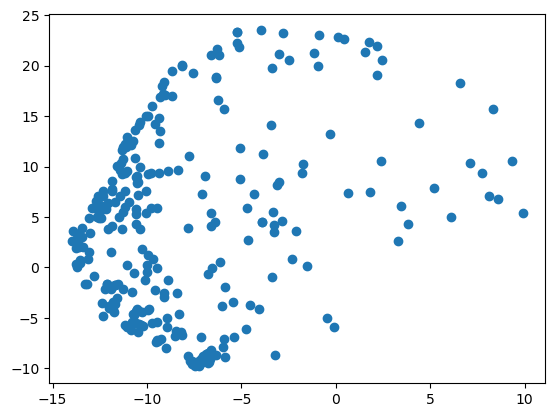

In [56]:
all_data = train_imgs + test_imgs + val_imgs
embeddings = []
for motion in all_data:
    emb = get_motion_embedding(encoder, motion, tform)
    embeddings.append(emb)
embeddings = np.array(embeddings)

x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y)
plt.show()

### По ошибкам

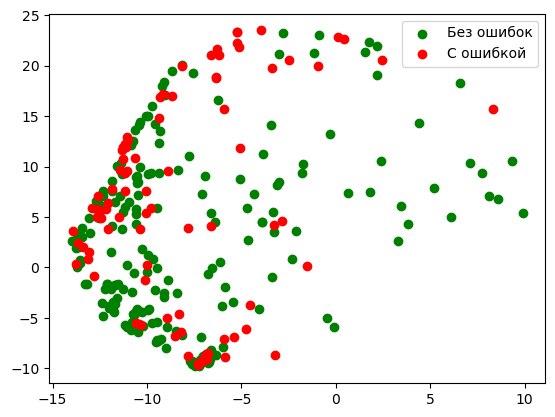

In [57]:
# separate on mistakes
normal = []
wrong = []
for motions, labels in zip([train_imgs, test_imgs, val_imgs], [train_labels, test_labels, val_labels]):
    for idx, motion in enumerate(motions):
        if labels[idx][0] != 0: # with errors
            wrong.append(get_motion_embedding(encoder, motion, tform))
        else:
            normal.append(get_motion_embedding(encoder, motion, tform))
normal = np.array(normal)
wrong = np.array(wrong)

for clr_code, points in zip(["green", "red"], [normal, wrong]):
    x = points[:, 0]
    y = points[:, 1]
    plt.scatter(x, y, c=clr_code)
plt.legend(["Без ошибок", "С ошибкой"])
plt.show()

### По упражнениям

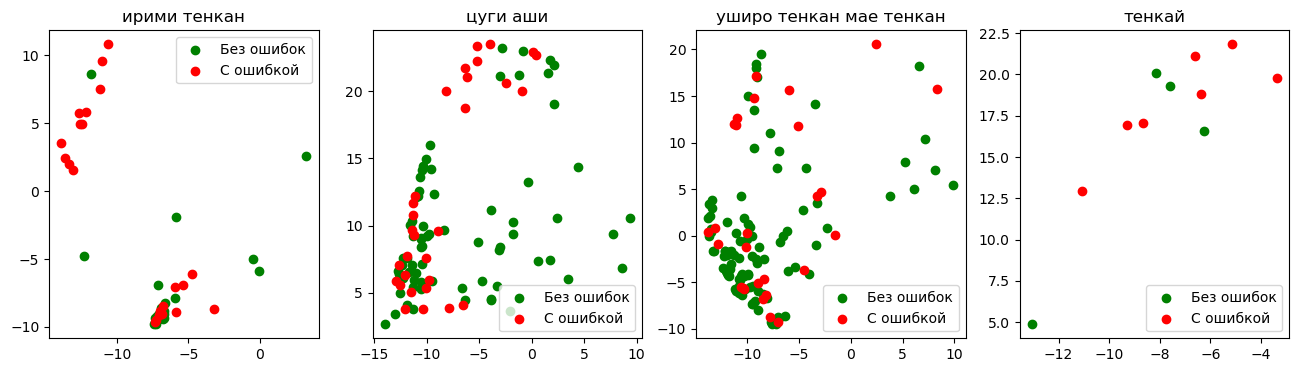

In [77]:
fig, axs = plt.subplots(1, len(exercise2points), figsize=(16, 4))
for idx, exname in enumerate(exercise2points):
    wrong_exercises = []
    normal_exercises = []
    for student in exercise2points[exname]:
        for m_idx, motion in enumerate(exercise2points[exname][student]):
            if exercise2errors[exname][student][m_idx][0] != 0:
                wrong_exercises.append(get_motion_embedding(encoder, motion, tform))
            else:
                normal_exercises.append(get_motion_embedding(encoder, motion, tform))
    wrong_exercises = np.array(wrong_exercises)
    normal_exercises = np.array(normal_exercises)
    for ccode, exer in zip(["green", "red"], [normal_exercises, wrong_exercises]):
        x = exer[:, 0]
        y = exer[:, 1]
        axs[idx].scatter(x, y, c=ccode)
    axs[idx].legend(["Без ошибок", "С ошибкой"])
    axs[idx].title.set_text(exname)
plt.show() 